# Purpose of this file:

The file is just used for debugging purposes. It is used to check if the code is working as expected.

In [9]:
# importing modules
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
def parse_file(file_path: str):
    """
    Parse the file and return the abstract syntax tree

    Args:
    file_path: The path to the file to be parsed

    Returns:
    The abstract syntax tree of the file
    """
    with open(file_path, 'r') as f:
        tree = ast.parse(f.read())
    return tree

In [11]:
def extract_functions(tree):
    """ 
    Extract all the functions from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions with the function name as the key and the function's
    """
    functions = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls" : [],
                'line' : node.lineno
            }
    return functions

In [12]:
def analyze_function_calls(tree, functions):
    """ 
    Analyze the function calls in the abstract syntax tree and update the functions dictionary

    Args:
    tree: The abstract syntax tree of the file
    functions: The dictionary of functions with the function name as the key and the function's

    Returns:
    None
    """
    for node in ast.walk(tree):
        if isinstance(node, ast.Call) and isinstance(node.func, ast.Name):
            caller = None
            for parent in ast.walk(tree):
                if isinstance(parent, ast.FunctionDef) and node in ast.walk(parent):
                    caller = parent.name
                    break
            if caller and node.func.id in functions:
                functions[caller]['calls'].append(node.func.id)

In [13]:
def create_graph(functions):
    """ 
    Create a directed graph of the functions and their calls

    Args:
    functions: The dictionary of functions with the function name as the key and the function's

    Returns:
    A directed graph of the functions and their calls
    """
    G = nx.DiGraph()
    for func, data in functions.items():
        G.add_node(func)
        for call in data['calls']:
            G.add_edge(func, call)
    return G

In [29]:
def visualize_graph(G):
    """ 
    Visualize the directed graph of the functions and their calls

    Args:
    G: A directed graph of the functions and their calls

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))  # Increase figure size
    pos = nx.spring_layout(G, k=0.9, iterations=50)  # Adjust layout for more spacing
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    
    # Add edge labels (function names)
    edge_labels = {(u, v): u for (u, v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Function Call Graph", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

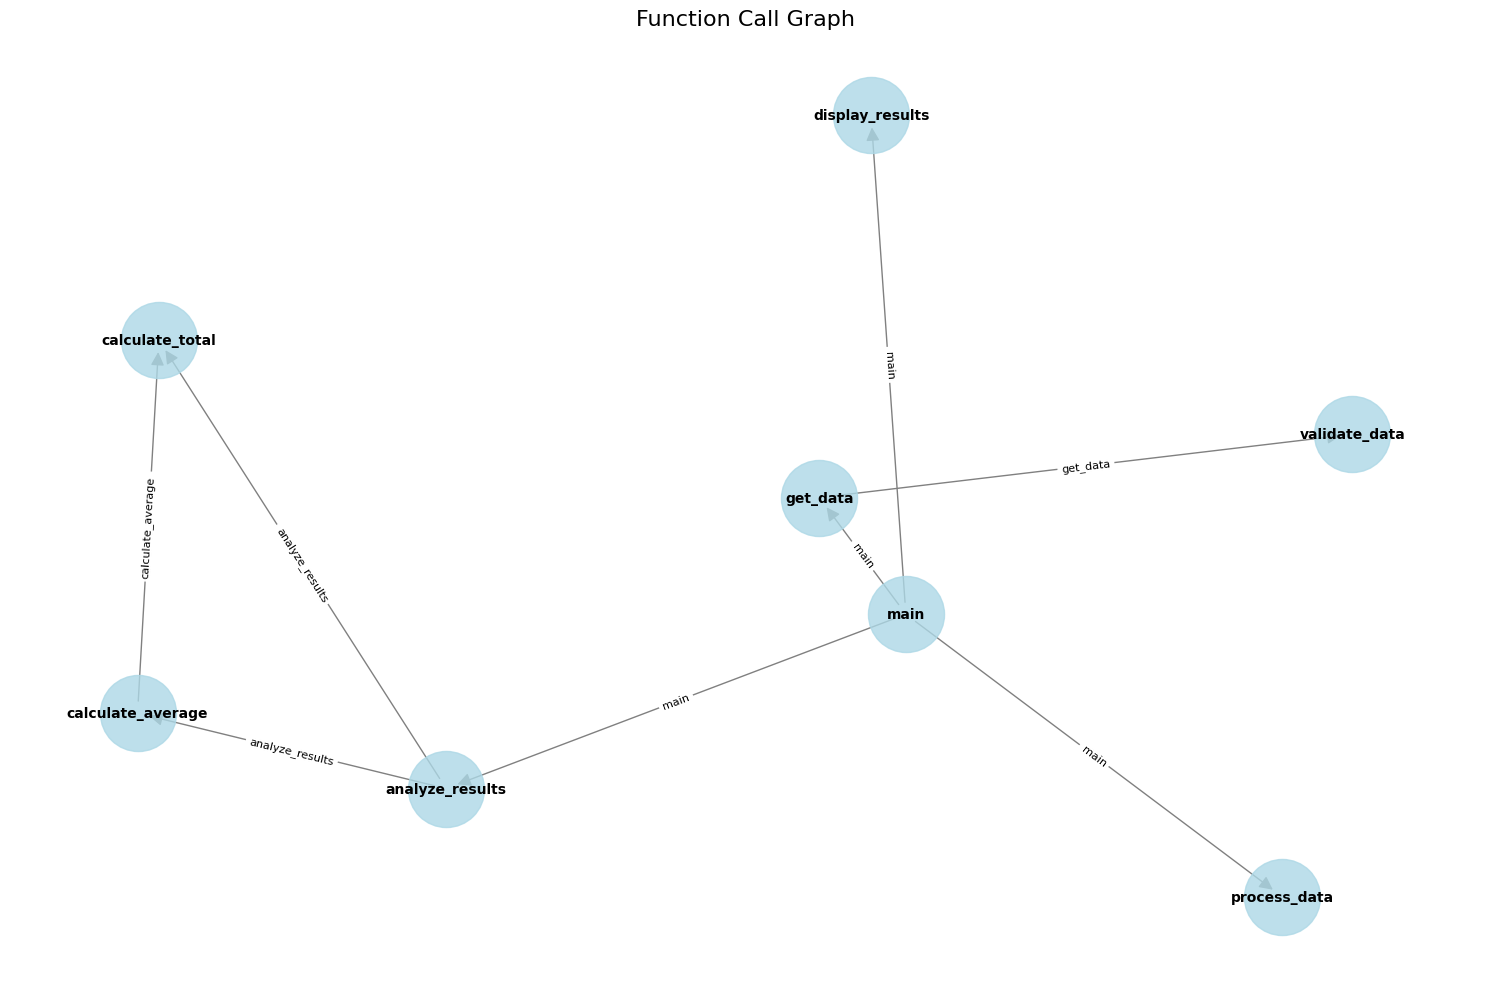

In [30]:
def main():
    """ 
    Main function to run the program
    """
    file_path = input("Enter the path to the Python file: ")
    tree = parse_file(file_path)
    functions = extract_functions(tree)
    analyze_function_calls(tree, functions)
    G = create_graph(functions)
    visualize_graph(G)

if __name__ == "__main__":
    main()

## For the whole directory

In [77]:
# importing modules
import os
import ast
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [78]:
def parse_directory(directory_path: str):
    """  
    Parse the directory and return all the python files in that directory

    Args:
    directory_path: The path to the directory

    Returns:
    A list of all the python files in the directory
    """
    python_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".py"):
                python_files.append(os.path.join(root, file))
    return python_files

In [79]:
def parse_file(file_path: str):
    """
    Parse the file and return the abstract syntax tree

    Args:
    file_path: The path to the file to be parsed

    Returns:
    The abstract syntax tree of the file
    """
    with open(file_path, 'r') as f:
        tree = ast.parse(f.read())
    return tree

In [80]:
def extract_functions(tree):
    """ 
    Extract all the functions from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions with the function name as the key and the function's
    """
    functions = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls" : [],
                'line' : node.lineno,
                'file': None
            }
    return functions

In [94]:
def extract_functions_and_imports(tree):
    """ 
    Extract all the functions and imported modules from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions and imports with the function name as the key and the function's data
    """
    functions = {}
    imports = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls": [],
                'line': node.lineno,
                'file': None
            }
        elif isinstance(node, ast.Import) or isinstance(node, ast.ImportFrom):
            for alias in node.names:
                imports.add(alias.name.split('.')[0])  # Add imported module names
    return functions, imports

In [95]:
def analyze_function_calls(tree, functions):
    """ 
    Analyze the function calls in the abstract syntax tree and update the functions dictionary

    Args:
    tree: The abstract syntax tree of the file
    functions: The dictionary of functions with the function name as the key and the function's

    Returns:
    None
    """
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            caller = None
            for parent in ast.walk(tree):
                if isinstance(parent, ast.FunctionDef) and node in ast.walk(parent):
                    caller = parent.name
                    break
            if caller and caller in functions:
                if isinstance(node.func, ast.Name):
                    called_func = node.func.id
                    functions[caller]['calls'].append(called_func)
                elif isinstance(node.func, ast.Attribute):
                    called_func = node.func.attr
                    if isinstance(node.func.value, ast.Name):
                        object_name = node.func.value.id
                        functions[caller]['calls'].append(called_func)

In [96]:
def create_graph(functions, imports, file_paths):
    """ 
    Create a directed graph of the functions, their calls, and imports

    Args:
    functions: The dictionary of functions with the function name as the key and the function's data
    imports: The set of imported modules
    file_paths: A list of file paths

    Returns:
    A directed graph of the functions, their calls, and imports
    """
    G = nx.DiGraph()
    
    for file_path in file_paths:
        module_name = os.path.basename(file_path).replace('.py', '')
        for func, data in functions.items():
            if data['file'] == file_path:
                G.add_node(func, module=module_name)
                for call in data['calls']:
                    if call in functions:
                        G.add_edge(func, call)

    # Add imported modules as isolated nodes
    for module in imports:
        G.add_node(module, module='import')
    
    return G

In [91]:
def visualize_graph(G):
    """ 
    Visualize the directed graph of the functions and their calls

    Args:
    G: A directed graph of the functions and their calls

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    modules = set(nx.get_node_attributes(G, 'module').values())
    colors = plt.cm.rainbow(np.linspace(0, 1, len(modules)))
    color_map = dict(zip(modules, colors))
    
    for module in modules:
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=[n for n, d in G.nodes(data=True) if d['module'] == module],
                               node_color=color_map[module], 
                               node_size=3000, alpha=0.8, label=module)
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    
    plt.title("Function Call Graph", fontsize=16)
    plt.axis('off')
    # plt.legend()
    plt.tight_layout()
    plt.show()

c:\Users\Vishal\Github\CodeFlowMapper\venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


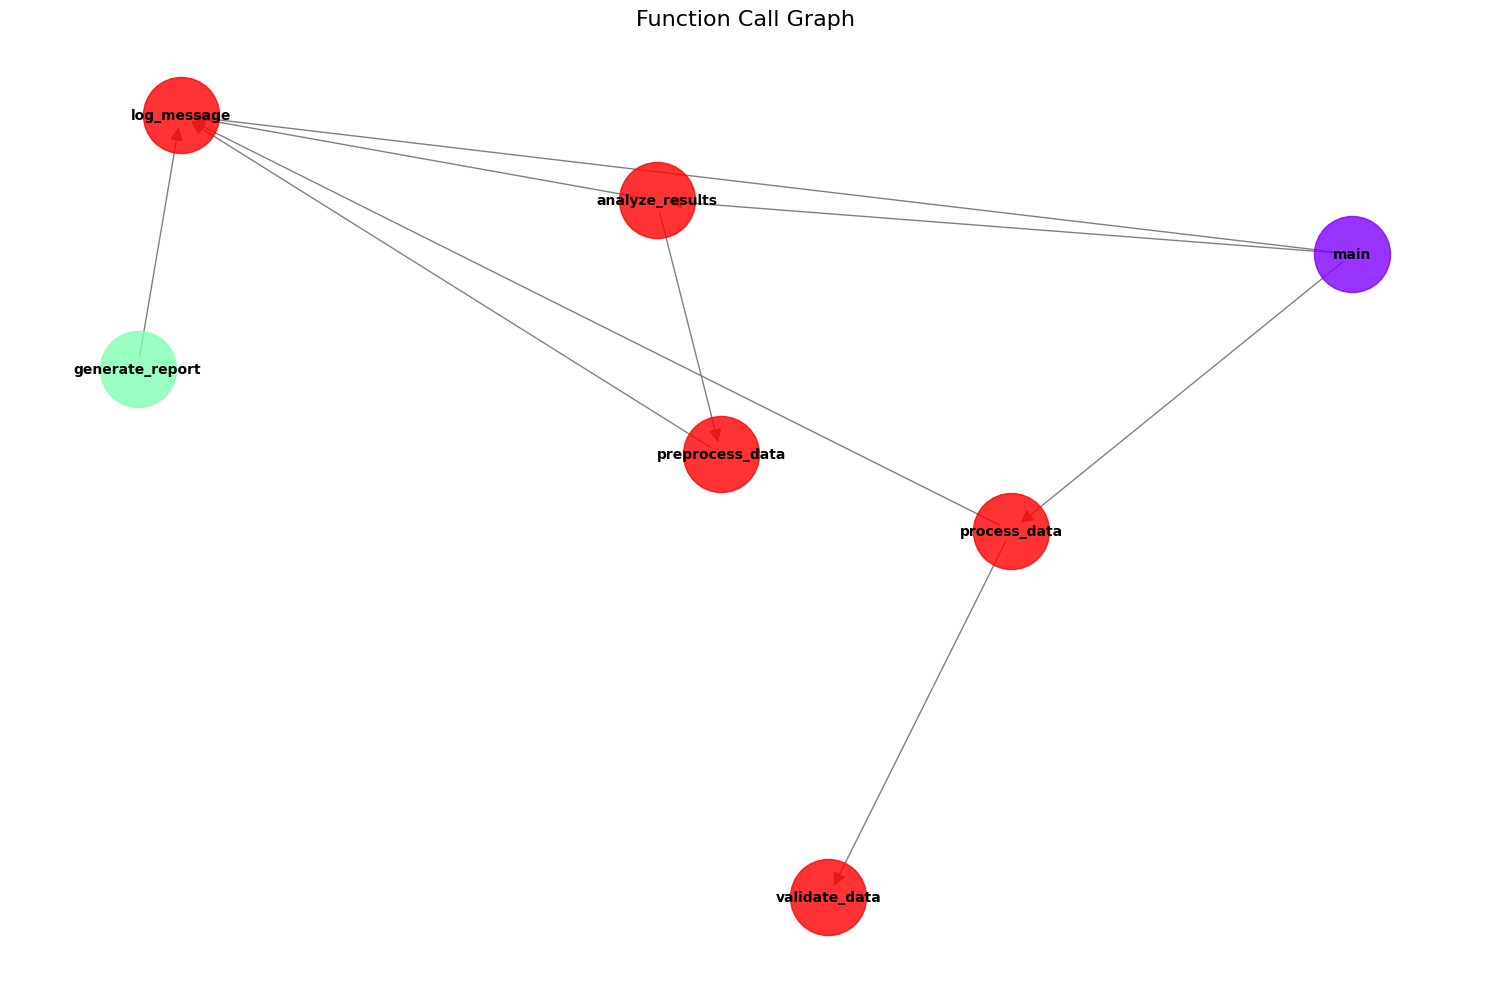

In [97]:
def main():
    """ 
    Main function to run the program
    """
    directory_path = input("Enter the path to the directory: ")

    python_files = parse_directory(directory_path)

    functions = {}
    imports = set()
    for file_path in python_files:
        tree = parse_file(file_path)
        file_functions, file_imports = extract_functions_and_imports(tree)
        
        # Add file path information to each function
        for func_name, func_data in file_functions.items():
            func_data['file'] = file_path
        
        functions.update(file_functions)
        imports.update(file_imports)
        analyze_function_calls(tree, functions)

    G = create_graph(functions, imports, python_files)
    visualize_graph(G)

if __name__ == "__main__":
    main()